In [54]:
import polars as pl
import polars.selectors as cs
import polars_ds as ds
import polars_xdt as xdt
import pickle
from datetime import date
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from model import model_pipeline
from features import *
from plotnine import (
    ggplot,
    aes,
    geom_bar,
    geom_histogram,
    coord_flip,
    theme_classic,
    theme,
    labs,
    facet_wrap,
    theme_minimal,
    theme_bw,
    scale_x_continuous,
)

In [55]:
df = pl.read_csv("train_sessions.csv")

In [56]:
df.group_by("target").agg(pl.len())

target,len
i64,u32
0,251264
1,2297


In [57]:
df = df.rename({"target": "target_bool"})
df = df.with_columns(
    pl.col("target_bool")
    .cast(pl.String)
    .replace("1", "Alice")
    .replace("0", "Somebody else")
    .alias("target")
)

## Feature engineering and data preparation

In [58]:
df = transform_to_datetime(df)

In [59]:
df.head()

session_id,site1,datetime1,site2,datetime2,site3,datetime3,site4,datetime4,site5,datetime5,site6,datetime6,site7,datetime7,site8,datetime8,site9,datetime9,site10,datetime10,target_bool,target
i64,i64,datetime[μs],i64,datetime[μs],i64,datetime[μs],i64,datetime[μs],i64,datetime[μs],i64,datetime[μs],i64,datetime[μs],i64,datetime[μs],i64,datetime[μs],i64,datetime[μs],i64,str
1,718,2014-02-20 10:02:45,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,"""Somebody else"""
2,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50,3847,2014-02-22 11:19:51,941,2014-02-22 11:19:51,942,2014-02-22 11:19:51,3846,2014-02-22 11:19:51,3847,2014-02-22 11:19:52,3846,2014-02-22 11:19:52,1516,2014-02-22 11:20:15,1518,2014-02-22 11:20:16,0,"""Somebody else"""
3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,2013-12-16 16:40:19,39,2013-12-16 16:40:19,14768,2013-12-16 16:40:20,14768,2013-12-16 16:40:21,14768,2013-12-16 16:40:22,14768,2013-12-16 16:40:24,0,"""Somebody else"""
4,782,2014-03-28 10:52:12,782,2014-03-28 10:52:42,782,2014-03-28 10:53:12,782,2014-03-28 10:53:42,782,2014-03-28 10:54:12,782,2014-03-28 10:54:42,782,2014-03-28 10:55:12,782,2014-03-28 10:55:42,782,2014-03-28 10:56:12,782,2014-03-28 10:56:42,0,"""Somebody else"""
5,22,2014-02-28 10:53:05,177,2014-02-28 10:55:22,175,2014-02-28 10:55:22,178,2014-02-28 10:55:23,177,2014-02-28 10:55:23,178,2014-02-28 10:55:59,175,2014-02-28 10:55:59,177,2014-02-28 10:55:59,177,2014-02-28 10:57:06,178,2014-02-28 10:57:11,0,"""Somebody else"""


Create a feature for tld

In [60]:
with open("site_dic.pkl", "rb") as f:
    sites = pickle.load(f)


sites = pl.DataFrame(sites)
sites = sites.unpivot(cs.all(), variable_name="sitename", value_name="site")
sites = sites.sort(by="sitename")

In [61]:
sites = (
    sites
    # Split after dot. The last item in the list is the TLD
    .with_columns(pl.col("sitename").str.split(".").list.last().alias("tld"))
    # Categorize TLDs
    .with_columns(
        pl.when(pl.col("tld").is_in(["com", "org", "net"]))
        .then(pl.lit(1))
        .otherwise(pl.lit(0))
        .alias("is_common_tld")
    )
)

sites

sitename,site,tld,is_common_tld
str,i64,str,i32
"""0.0-02.net""",24314,"""net""",1
"""0.56.web1.im.weibo.com""",43357,"""com""",1
"""0.academia-assets.com""",18340,"""com""",1
"""0.academia-photos.com""",32767,"""com""",1
"""0.api.urban-rivals.com""",35936,"""com""",1
…,…,…,…
"""zurich.cloudsigma.cedexis.com""",3994,"""com""",1
"""zv1ec6njx7.b.ad6media.fr""",44705,"""fr""",0
"""zvon.org""",2498,"""org""",1


In [62]:
df.columns

['session_id',
 'site1',
 'datetime1',
 'site2',
 'datetime2',
 'site3',
 'datetime3',
 'site4',
 'datetime4',
 'site5',
 'datetime5',
 'site6',
 'datetime6',
 'site7',
 'datetime7',
 'site8',
 'datetime8',
 'site9',
 'datetime9',
 'site10',
 'datetime10',
 'target_bool',
 'target']

In [63]:
# Join is_common_tld to df. First unpivot and thereafter join. Pivot back in the end.
def site_mapping(df):
    df = (
        df.unpivot(
            index=df.select(~cs.starts_with("site")).columns,
            on=cs.starts_with("site"),
            variable_name="site_session_id",
            value_name="site",
        )
        .join(sites.select("site", "is_common_tld"), on=["site"], how="left")
        .pivot(index=df.select(~cs.starts_with("site")).columns, on=["site_session_id"])
        # Get original column names for site
        .with_columns(pl.all().name.map(lambda x: x.replace("site_", "")))
        # Drop duplicate columns
        .drop(cs.starts_with("site_"))
    )
    return df


# Run function
df = site_mapping(df)

In [64]:
df.shape

(253561, 33)

In [67]:
df.tail()

session_id,datetime1,datetime2,datetime3,datetime4,datetime5,datetime6,datetime7,datetime8,datetime9,datetime10,target_bool,target,is_common_tld_site1,is_common_tld_site2,is_common_tld_site3,is_common_tld_site4,is_common_tld_site5,is_common_tld_site6,is_common_tld_site7,is_common_tld_site8,is_common_tld_site9,is_common_tld_site10,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,field_0,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,field_10
i64,datetime[μs],datetime[μs],datetime[μs],datetime[μs],datetime[μs],datetime[μs],datetime[μs],datetime[μs],datetime[μs],datetime[μs],i64,str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
253557,2013-11-25 10:26:54,2013-11-25 10:26:58,2013-11-25 10:27:03,2013-11-25 10:27:04,2013-11-25 10:27:13,2013-11-25 10:27:16,2013-11-25 10:27:28,2013-11-25 10:27:40,2013-11-25 10:27:52,2013-11-25 10:27:53,0,"""Somebody else""",1,1,1,0,1,0,0,0,0,0,3474,3474,141,2428,106,2428,2428,2428,2428,148,-3.12474,0.594307,-0.526233,1.219321,-2.404561,0.475142,-1.222825,-2.535281,1.100885,-4.073804,-3.629832
253558,2013-03-12 16:01:15,2013-03-12 16:01:16,2013-03-12 16:01:16,2013-03-12 16:01:17,2013-03-12 16:01:17,2013-03-12 16:01:17,2013-03-12 16:01:18,2013-03-12 16:01:18,2013-03-12 16:01:18,2013-03-12 16:01:18,0,"""Somebody else""",0,0,1,1,1,1,1,1,1,0,12727,12727,2215,38,2215,23,25444,2215,23,21,-1.386287,0.484686,0.090434,0.517604,0.40157,1.13119,0.854204,0.493521,-0.701147,-0.641396,-1.599694
253559,2013-09-12 14:05:03,2013-09-12 14:05:10,2013-09-12 14:05:10,2013-09-12 14:06:29,2013-09-12 14:06:30,null,null,null,null,null,0,"""Somebody else""",1,0,0,0,0,null,null,null,null,null,2661,15004,5562,5562,5562,null,null,null,null,null,-0.444253,1.556391,0.616049,1.793286,-0.628701,0.857047,-0.973232,1.545825,-0.890789,-2.809582,-1.052273
253560,2013-12-19 15:20:22,2013-12-19 15:20:22,2013-12-19 15:20:22,2013-12-19 15:20:22,2013-12-19 15:20:22,2013-12-19 15:20:23,2013-12-19 15:20:23,2013-12-19 15:20:23,2013-12-19 15:20:24,2013-12-19 15:20:24,0,"""Somebody else""",1,1,1,1,1,1,1,1,1,1,812,676,814,22,39,812,814,570,22,570,-3.127048,-0.535522,-1.178704,-0.599046,-2.358794,0.361103,-0.640126,2.202076,-0.950471,-4.164101,-0.64298
253561,2014-04-25 09:56:52,2014-04-25 09:56:53,2014-04-25 09:56:53,2014-04-25 09:56:54,2014-04-25 09:56:54,2014-04-25 09:56:54,2014-04-25 09:56:54,2014-04-25 09:56:55,2014-04-25 09:56:55,2014-04-25 09:56:55,0,"""Somebody else""",1,0,1,1,1,1,1,1,1,1,34942,1429,34942,29,30,34942,5779,30,35,33,-1.141031,-1.022345,-0.233542,-0.494624,0.002813,1.496069,0.409772,0.040373,1.84265,-1.732289,-1.001869


Check how many weeks, days, months there are in a whole session. If there are only 1, booleans of months and weeks can be created from datetime1. Accoring to the calculation in the next cell we see that there are only 2 unique weeks and 2 unique month in the session. So we can create a boolean column for each of them from datetime1.


In [11]:
(
    df.select("session_id", cs.contains("datetime"))
    .unpivot(index="session_id", on=cs.contains("datetime"))
    .with_columns(
        pl.col("value").dt.month().alias("month"),
        pl.col("value").dt.week().alias("week"),
        pl.col("value").dt.day().alias("day"),
    )
    .group_by("session_id")
    .agg(
        pl.col("month").n_unique().alias("num_months"),
        pl.col("week").n_unique().alias("num_week"),
        pl.col("day").n_unique().alias("num_day"),
    )
    .select(
        pl.col("num_months").max(), pl.col("num_week").max(), pl.col("num_day").max()
    )
)

num_months,num_week,num_day
u32,u32,u32
2,2,2


In [68]:
df = (
    df.pipe(diff_time)
    .pipe(total_duration)
    .pipe(num_sites)
    .pipe(time_of_day)
    .pipe(months)
    .pipe(weeks)
    .pipe(days)
    .pipe(is_workday)
)

Distribution of number of unique sites visited per session id seems almost the same

c:\Users\Yafee Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.


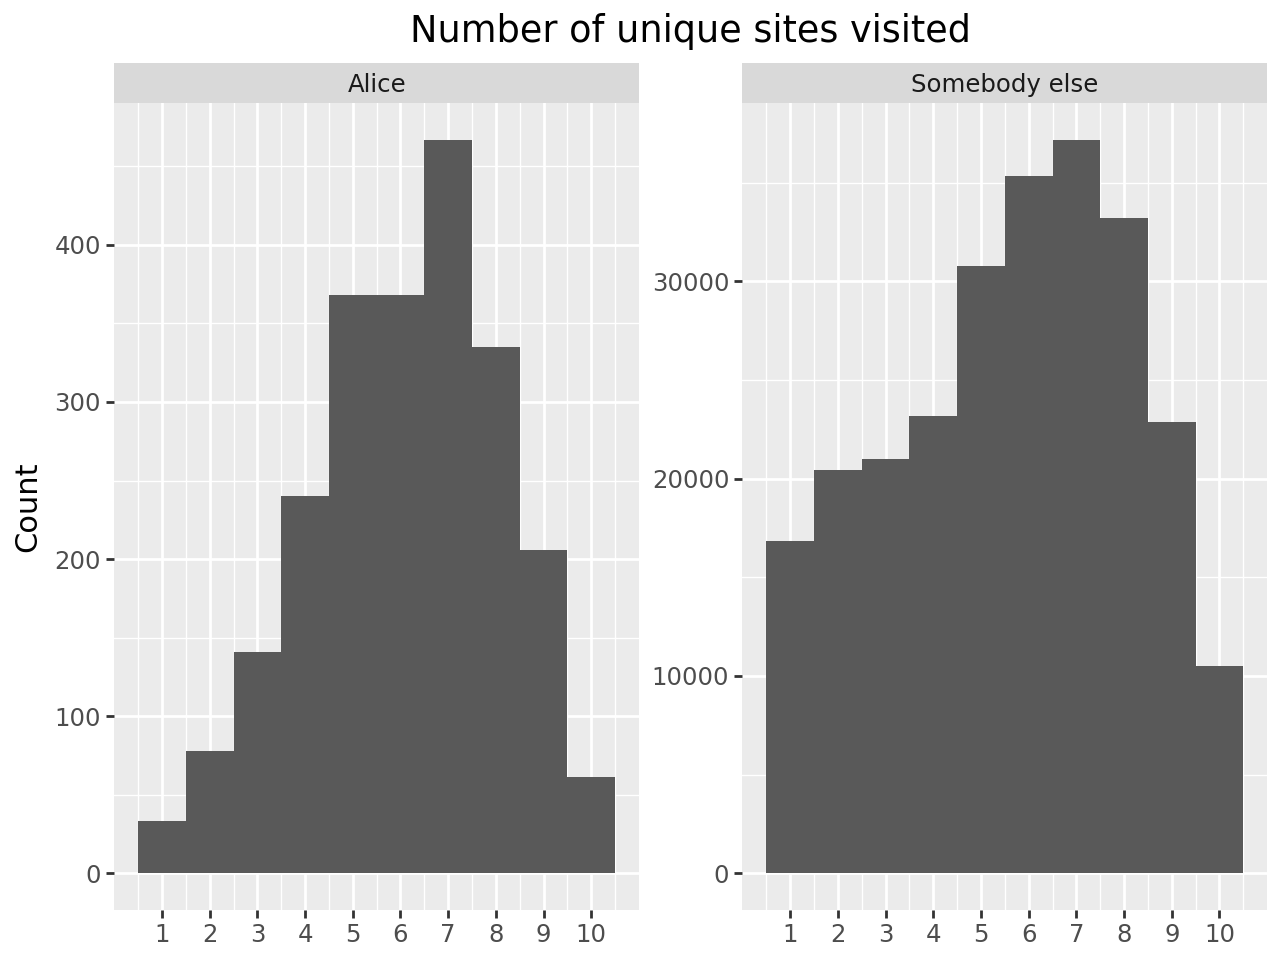

In [15]:
(
    ggplot(data=df, mapping=aes(x="num_sites"))
    + geom_histogram(bins=10)
    + scale_x_continuous(breaks=range(df["num_sites"].min(), df["num_sites"].max() + 1))
    + facet_wrap("target", scales="free_y")
    + labs(x="", y="Count", title="Number of unique sites visited")
    + theme()
)

In [16]:
(
    df.group_by("target").agg(
        pl.col("num_sites").mean().alias("mean_num_sites"),
        pl.col("num_sites").median().alias("median_num_sites"),
    )
)

target,mean_num_sites,median_num_sites
str,f64,f64
"""Somebody else""",5.634086,6.0
"""Alice""",6.109273,6.0


In [17]:
(
    df.filter(pl.col("target") == "Alice")
    .group_by("all_sites", "target")
    .agg(pl.len().alias("num_sites"))
    .sort(by="num_sites")
)

all_sites,target,num_sites
list[i64],str,u32
"[270, 32, … 29]","""Alice""",1
"[80, 27296, … 27296]","""Alice""",1
"[942, 3876, … 941]","""Alice""",1
"[704, 33, … 3000]","""Alice""",1
"[855, 1520, … 1515]","""Alice""",1
…,…,…
"[229, 21, … 21]","""Alice""",2
"[80, 81, … 81]","""Alice""",2
"[80, 80, … 80]","""Alice""",4


In [ ]:
df.group_by("session_id").agg(pl.col(""))

## Create ML model

In [70]:
features = df.select(
    cs.contains("week_"),
    cs.contains("diff_time_"),
    cs.contains("time_of_day"),
    cs.contains("month_"),
    cs.contains('field'),
    # cs.contains('weekday_'),
    # cs.starts_with('is_common_tld'),
    "is_workday",
    "total_duration",
    "num_sites",
).columns

X = df.select(*features)
y = df.select("target_bool")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

Run grid search

# Predict the test set

In [ ]:
test_set = pl.read_csv("test_sessions.csv")

test_set = (
    test_set.pipe(transform_to_datetime)
    .pipe(diff_time)
    .pipe(total_duration)
    .pipe(num_sites)
    .pipe(time_of_day)
    .pipe(months)
    .pipe(weeks)
    .pipe(days)
    .pipe(is_workday)
    # .pipe(site_mapping)
)


# Select features
X_test_set = test_set.select(*features)

## Create model

In [74]:
# xgoost_model   = model_pipeline(X_train,y_train,'xgboost')
catboost_model = model_pipeline(X_train, y_train, "catboost")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


Run predictions

In [81]:
test_set_predictions = catboost_model.predict_proba(X_test_set.to_pandas())[:, 1]
test_set_predictions = pl.from_numpy(test_set_predictions).rename(
    {"column_0": "target"}
)
test_set_predictions = pl.concat(
    [test_set.select("session_id"), test_set_predictions], how="horizontal"
)
test_set_predictions.write_csv("test_set_predictions.csv")

In [78]:
X_test_set

week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,…,time_of_day_datetime5_afternoon,time_of_day_datetime5_evening,time_of_day_datetime6_night,time_of_day_datetime6_morning,time_of_day_datetime6_afternoon,time_of_day_datetime6_evening,time_of_day_datetime7_night,time_of_day_datetime7_morning,time_of_day_datetime7_afternoon,time_of_day_datetime7_evening,time_of_day_datetime8_night,time_of_day_datetime8_morning,time_of_day_datetime8_afternoon,time_of_day_datetime8_evening,time_of_day_datetime9_night,time_of_day_datetime9_morning,time_of_day_datetime9_afternoon,time_of_day_datetime9_evening,time_of_day_datetime10_night,time_of_day_datetime10_morning,time_of_day_datetime10_afternoon,time_of_day_datetime10_evening,month_january,month_february,month_march,month_april,month_may,month_june,month_july,month_august,month_september,month_october,month_november,month_december,is_workday,total_duration,num_sites
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,…,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i64,i64,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,7,10
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,…,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,85,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,84,2
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,4,7
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,13,8
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0,0,0,0,0,0,0,0,1,0,0,1,null,3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,39,6
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,8,10
